# Importing data and libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
all_xray_df = pd.read_csv('Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('combined_data', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

Scans found: 25591 , Total Headers 112120


## To loop through images files and take only rows for which the images are available

In [6]:

image_present = []

for i in all_image_paths.keys():
    image_present.append(i)


new_df= all_xray_df[all_xray_df['Image Index'].isin(image_present)]

In [7]:
all_xray_df = new_df

In [8]:
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)



All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
13119,00003421_004.png,No Finding,4,3421,41,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34040,00008911_012.png,Infiltration,12,8911,63,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2423,00000627_018.png,No Finding,18,627,58,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
# data split

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2019)
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 19193 test 6398


In [10]:
from PIL import Image
import numpy as np
import os
from random import shuffle
import matplotlib.pyplot as plt


In [11]:

# Want to know how we should format the height x width image data dimensions
# for inputting to a keras model
def get_size_statistics():
    heights = []
    widths = []
    img_count = 0
    for img in os.listdir("combined_data"):
        path = os.path.join("combined_data", img)
        if "DS_Store" not in path:
            data = np.array(Image.open(path))
            heights.append(data.shape[0])
            widths.append(data.shape[1])
            img_count += 1
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

get_size_statistics()

Average Height: 1024.0
Max Height: 1024
Min Height: 1024


Average Width: 1024.0
Max Width: 1024
Min Width: 1024


In [12]:
train_df_in = train_df.set_index('Image Index')
test_df_in = test_df.set_index('Image Index')
all_xray_df_in = all_xray_df.set_index('Image Index')

In [13]:
def label_img(name):
    word_label = all_xray_df_in.loc[name,'No Finding']
    return word_label


In [14]:
IMG_SIZE = 128

def load_training_data():
    train_data = []
    for img in os.listdir('combined_data'):
        label = label_img(img)
        path = os.path.join('combined_data', img)
        if "DS_Store" not in path:
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            train_data.append([np.array(img), label])
            
    shuffle(train_data)
    return train_data

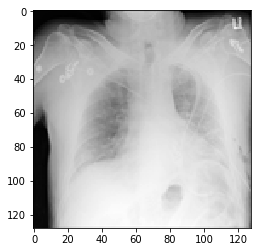

In [16]:
train_data = load_training_data()
plt.imshow(train_data[43][0], cmap = 'gist_gray')

In [17]:
trainImages = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
trainLabels = np.array([i[1] for i in train_data])

In [18]:
trainImages_new = trainImages[:15000]
testImages_new = trainImages[15000:]

trainLabels_new = trainLabels[:15000]
testLabels_new = trainLabels[15000:]

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
import numpy as np

In [2]:
IMG_SIZE = 128

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))


In [3]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy','binary_accuracy'])


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
__________

In [23]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('xray_mobnetv2')

# Save the model after every epoch.
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience= 4)
callbacks_list = [checkpoint, early]

In [25]:
model.fit(trainImages_new, trainLabels_new, batch_size = 50, epochs = 5, verbose = 1)

Epoch 1/5
15000/15000 [==============================] - 363s 24ms/step - loss: 0.6735 - acc: 0.6013 - binary_accuracy: 0.6013
Epoch 2/5
15000/15000 [==============================] - 374s 25ms/step - loss: 0.6503 - acc: 0.6273 - binary_accuracy: 0.6273
Epoch 3/5
15000/15000 [==============================] - 359s 24ms/step - loss: 0.6384 - acc: 0.6397 - binary_accuracy: 0.6397
Epoch 4/5
15000/15000 [==============================] - 363s 24ms/step - loss: 0.6322 - acc: 0.6485 - binary_accuracy: 0.6485
Epoch 5/5
15000/15000 [==============================] - 353s 24ms/step - loss: 0.6265 - acc: 0.6547 - binary_accuracy: 0.6547


In [ ]:
# Save the model
model.save('binary_classification_cnn.h5', overwrite = False)

In [ ]:
pred_Y = model.predict(testImages_new, batch_size = 32, verbose = True)
pred_Y_trial = np.round(pred_Y)

In [28]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(testLabels_new, pred_Y_trial)

classification_report = metrics.classification_report(testLabels_new, pred_Y_trial)
print(confusion_matrix)
print(classification_report)

[[2979 1465]
 [2482 3665]]
              precision    recall  f1-score   support

         0.0       0.55      0.67      0.60      4444
         1.0       0.71      0.60      0.65      6147

    accuracy                           0.63     10591
   macro avg       0.63      0.63      0.63     10591
weighted avg       0.64      0.63      0.63     10591

